In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.tt.tasks.tt_RandomTarget import TT_RandomTarget
from ctd.comparison.analysis.dt.dt import Analysis_DT
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison

dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:
HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)

pathTT = HOME_DIR + 'content/trained_models/task-trained/20240419_RandomTarget_NoisyGRU_Final/max_epochs=1500 latent_size=64 seed=0/'
an_TT = TT_RandomTarget(run_name = "TT", filepath = pathTT)

# pathDT = pathTT + "20240402_NBFF_LFADS_DT_WDecay_Sweep2/gen_model=GRU_RNN prefix=20240328_NBFF_GRU_Final seed=0 max_epochs=1500 weight_decay=0.001/"
# an_DT = Analysis_DT(run_name = "DT", filepath = pathDT, model_type = "LFADS")

/home/csverst/Github/CtDBenchmark/



Iteration 10/4000
q = 1.83E-01 +/- 6.07E-02
dq = 1.85E-02 +/- 9.60E-03

Iteration 20/4000
q = 7.76E-02 +/- 3.26E-02
dq = 7.14E-03 +/- 4.37E-03

Iteration 30/4000
q = 3.86E-02 +/- 2.11E-02
dq = 3.69E-03 +/- 2.44E-03

Iteration 40/4000
q = 2.17E-02 +/- 1.50E-02
dq = 2.38E-03 +/- 1.80E-03

Iteration 50/4000
q = 1.40E-02 +/- 1.13E-02
dq = 1.63E-03 +/- 1.30E-03

Iteration 60/4000
q = 1.00E-02 +/- 8.85E-03
dq = 1.25E-03 +/- 9.85E-04

Iteration 70/4000
q = 7.84E-03 +/- 7.02E-03
dq = 1.06E-03 +/- 8.59E-04

Iteration 80/4000
q = 6.58E-03 +/- 5.48E-03
dq = 9.29E-04 +/- 8.49E-04

Iteration 90/4000
q = 5.84E-03 +/- 4.54E-03
dq = 9.02E-04 +/- 7.31E-04

Iteration 100/4000
q = 5.36E-03 +/- 3.73E-03
dq = 8.84E-04 +/- 7.15E-04

Iteration 110/4000
q = 4.99E-03 +/- 3.05E-03
dq = 8.60E-04 +/- 6.74E-04

Iteration 120/4000
q = 4.75E-03 +/- 2.62E-03
dq = 8.45E-04 +/- 6.57E-04

Iteration 130/4000
q = 4.61E-03 +/- 2.32E-03
dq = 8.24E-04 +/- 6.22E-04

Iteration 140/4000
q = 4.46E-03 +/- 2.06E-03
dq = 7.98E-04 

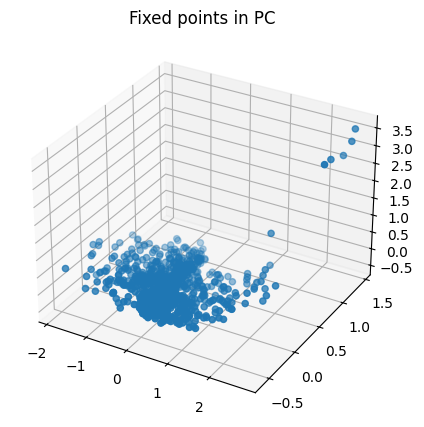

In [3]:
tt_fps = an_TT.compute_coupled_FPs(
    learning_rate=5e-3,
    noise_scale=0.1,
    n_inits = 1000,
    max_iters=4000,
    device = "cpu",
)


In [4]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

go_cues = an_TT.get_extra_inputs()[:,1]

x_star = tt_fps.xstar
print(x_star.shape)
# Split xstar into rnn_xstar and env_xstar [64, 14] respectively

env_xstar = x_star[:, :14]
rnn_xstar = x_star[:, 14:]
print(env_xstar.shape)
rnn_pca = PCA(n_components=3)
env_pca = PCA(n_components=3)

rnn_xstar_pca = rnn_pca.fit_transform(rnn_xstar)
env_xstar_pca = env_pca.fit_transform(env_xstar)

lats = an_TT.get_latents()
n_trials, n_time, n_latent = lats.shape
go_flag = go_cues > 0
inputs = an_TT.get_model_inputs()[2]
print(inputs.shape)

targs_end = inputs[go_flag,-1,:2].detach().numpy()
lats_end = lats[go_flag,-1,:].detach().numpy()
targs_start = inputs[go_flag,5,:2].detach().numpy()
lats_start = lats[go_flag,5,:].detach().numpy()

lats = lats.detach().cpu().numpy()
lm_end = LinearRegression().fit(lats_end, targs_end)
lats_targ = lm_end.predict(lats.reshape(-1, lats.shape[-1]))
lats_targ = lats_targ.reshape(n_trials,n_time, 2)
                           

lm_start = LinearRegression().fit(lats_start, targs_start)
lats_start = lm_start.predict(lats.reshape(-1, lats.shape[-1]))
lats_start = lats_start.reshape(n_trials,n_time, 2)


n_trials, n_time, n_latent = lats.shape
print(lats.shape)
lats = lats.reshape(-1, lats.shape[-1])
lats_pca = rnn_pca.transform(lats)
lats_pca = lats_pca.reshape(n_trials,n_time, 3)

rnn_xstar_targ = lm_end.predict(rnn_xstar)
rnn_xstar_start = lm_start.predict(rnn_xstar)



(1000, 78)
(1000, 14)
torch.Size([1000, 300, 2])
(1000, 300, 64)


In [5]:


def find_null_space(model):
    """
    Computes the null space of the coefficient matrix of a fitted LinearRegression model
    with multiple outputs.

    Parameters:
    model (LinearRegression): A fitted sklearn LinearRegression model.

    Returns:
    np.ndarray: A basis for the null space of the coefficient matrix.
    """
    # Coefficients of the model, shape [n_outputs, n_features] -> [2, 64]
    coef_matrix = model.coef_

    # Compute the Singular Value Decomposition (U, S, Vh) of the coefficient matrix
    U, S, Vh = np.linalg.svd(coef_matrix)

    # Identify zero (or nearly zero) singular values (adjust the tolerance if needed)
    tol = 1e-5
    rank = np.sum(S > tol)

    # Null space basis from the remaining columns of Vh
    null_space_basis = Vh.T[:, rank:]

    return null_space_basis
# Find neural activity orthogonal to the lm_end model
# Get the x target decoder vector

coefs = lm_end.coef_
U,S, Vh = np.linalg.svd(coefs)
print(Vh.shape)

null_space = find_null_space(lm_end)
lats_null = np.dot(lats, null_space)
lats_null = np.dot(lats_null, null_space.T)
preds = lm_end.predict(lats_null)

pca_null = PCA(n_components=1)
lats_null_pca = pca_null.fit_transform(lats_null)
lats_null_pca = lats_null_pca.reshape(n_trials, n_time, 1)

xstar_null = np.dot(rnn_xstar, null_space)
xstar_null = np.dot(xstar_null, null_space.T)

xstar_null_pca = pca_null.transform(xstar_null)


# 

(64, 64)


TypeError: only integer tensors of a single element can be converted to an index

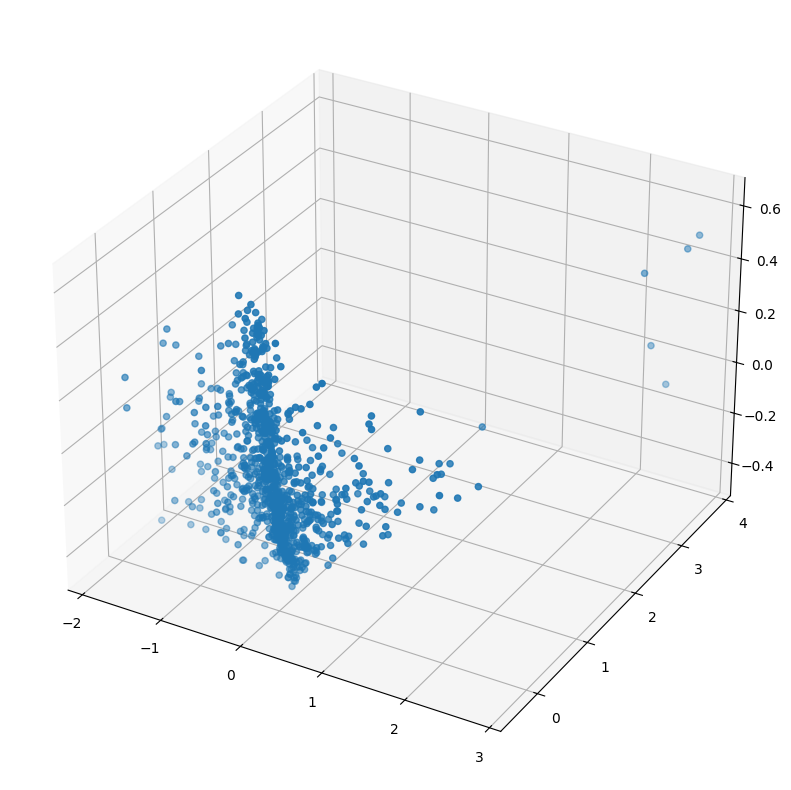

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rnn_xstar_pca[:, 0], rnn_xstar_pca[:, 1], rnn_xstar_pca[:, 2])
for i in range(100):
    ax.plot(lats_pca[i, go_cues[i]:, 0], lats_pca[i, go_cues[i]:, 1], lats_pca[i, go_cues[i]:, 2])
ax.scatter(lats_pca[:100,0,0], lats_pca[:100,0,1], lats_pca[:100,0,2], c='g')
ax.scatter(lats_pca[:100,-1,0], lats_pca[:100,-1,1], lats_pca[:100,-1,2], c='r')
# ax.set_xlim(-1, 0)
# ax.set_ylim(-1, 1)
# ax.set_zlim(-1, 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

(805,)


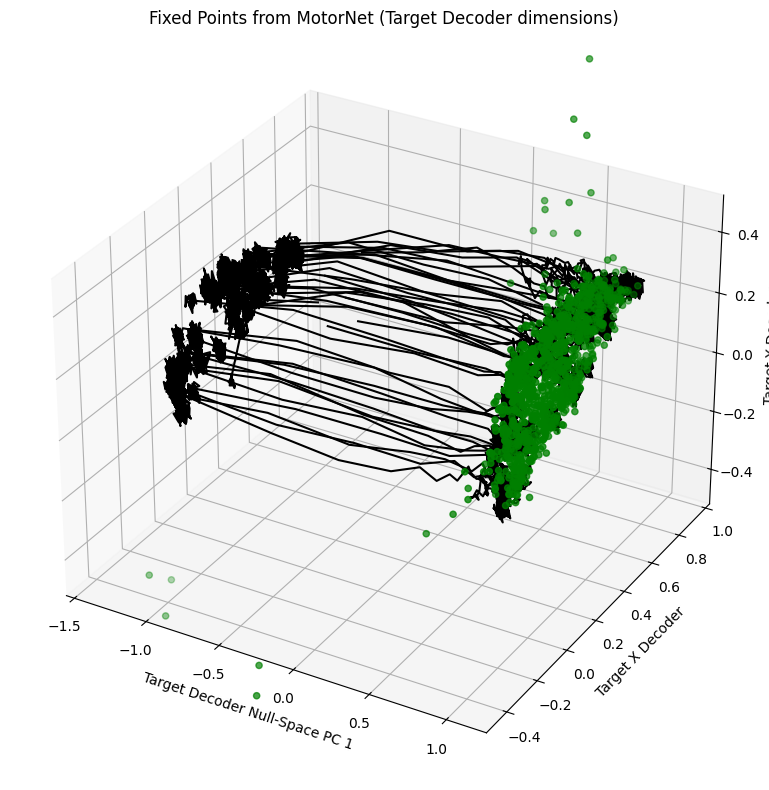

In [21]:
go_cues = an_TT.get_extra_inputs()[:,1].detach().numpy().astype(int)
go_cues = go_cues[go_cues > 0]
print(go_cues.shape)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xstar_null_pca[:, 0],rnn_xstar_targ[:, 0],   rnn_xstar_targ[:, 1], c = 'g', label = "Fixed Points")
for i in range(100):
    ax.plot(lats_null_pca[i, go_cues[i]:, 0], lats_targ[i, go_cues[i]:, 0],  lats_targ[i, go_cues[i]:, 1], c='k')
# ax.scatter(lats_null_pca[:100,0,0], lats_targ[:100,0,0],  lats_targ[:100,0,1], c='g')
# ax.scatter( lats_null_pca[:100,-1,0], lats_targ[:100,-1,0], lats_targ[:100,-1,1], c='r')
ax.set_xlim(-1.5, 1.2)
ax.set_ylim(-0.5, 1)
ax.set_zlim(-0.5, 0.5)
ax.set_xlabel("Target Decoder Null-Space PC 1")
ax.set_ylabel("Target X Decoder")
ax.set_zlabel("Target Y Decoder")

ax.set_title("Fixed Points from MotorNet (Target Decoder dimensions)")
# Tight layout
plt.tight_layout()
plt.savefig("fixed_points_target_decoder.pdf")

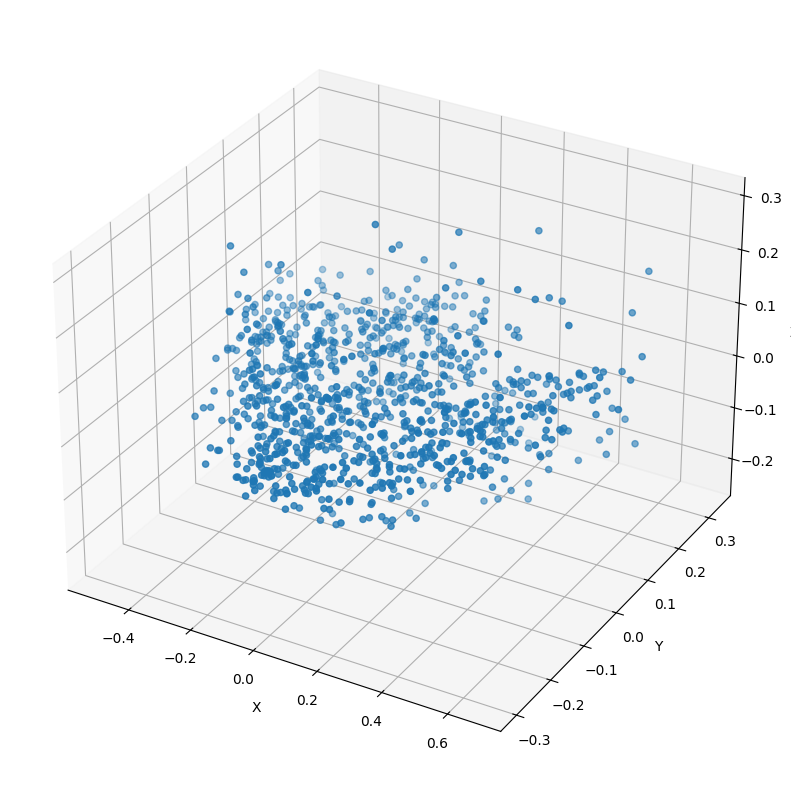

In [ ]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(env_xstar_pca[:, 0], env_xstar_pca[:, 1], env_xstar_pca[:, 2])

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

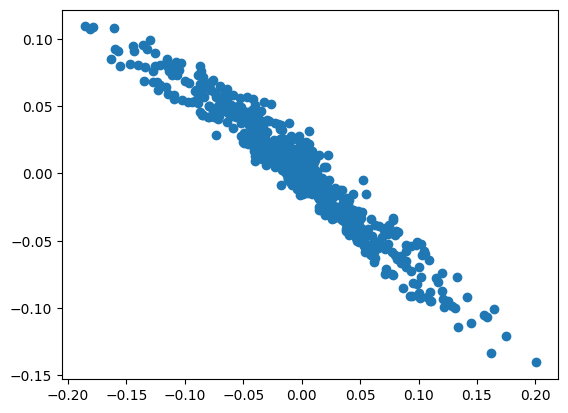

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(env_xstar[:, -2], env_xstar[:, -1])